# 미션 소개
- 이번 미션에서는  모델을 활용하여 FashionMNIST 데이터셋의 각 패션 아이템(예: 티셔츠, 바지, 스니커즈 등)을 조건부로 생성하는 작업을 수행합니다. 각 클래스에 해당하는 이미지를 생성하는 cGAN (Conditional GAN) 모델을 직접 설계하고 학습시켜 보세요.

# 데이터 소개
## 데이터 링크: torchvision.datasets.FashionMNIST
## 데이터 구성
훈련 데이터: 60,000장의 이미지
테스트 데이터: 10,000장의 이미지
28×28 크기의 흑백 이미지 (10개 클래스)
11개 클래스가 포함되어 있습니다.
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot



---


> **목차(Context)**

0.   개발 환경 세팅
1.   데이터 전처리
2.   모델링
3.   모델 평가
4.   총평






# **1. Setting**

In [26]:
#@title Improt lib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random

In [27]:
#@title Device 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [28]:
from google.colab import drive
drive.mount('/content/drive')
g_path = '/content/drive/MyDrive/Colab Notebooks/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#@ 일정한 결과값 확인을 위한 seed 설정
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

# **2. 데이터 전처리**

In [30]:
#@title 하이퍼파라미터 및 환경 설정

image_size = 28      # Fashion MNIST 이미지 크기
num_classes = 10     # 10개 클래스
latent_dim = 100     # 잠재 공간 차원
batch_size = 64      # 학습 배치 크기
num_epochs = 200     # 전체 학습 에폭 수
lr = 0.0002          # 학습률 (Learning Rate): GAN 학습 안정화를 위해 일반적으로 낮은 값 사용
beta1 = 0.5          # Adam optimizer beta1: DCGAN 논문에서 제안된 값으로 GAN 학습 안정화에 도움
beta2 = 0.999        # Adam optimizer beta2: Adam optimizer의 기본값

In [31]:
#@title Transform 설정

# 학습용 데이터 증강 transform
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),          # 20% 확률로 좌우 반전
    transforms.RandomRotation(10),                     # ±10도 범위 내에서 랜덤 회전
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 최대 10% 이동
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # 랜덤 크롭 후 28x28로 리사이즈
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 평가용 transform (증강 없이 정규화만)
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [32]:
#@title Dataset + Data Loader

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
test_dataset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [33]:
#@title 클래스 이름 설정 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
print("FashionMNIST classes:", idx_to_class)

FashionMNIST classes: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


# **3. 모델 생성**

In [34]:
#@title Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩: num_classes (10) 개의 클래스에 대해 각각 num_classes (10) 차원의 임베딩 벡터 생성
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # 초기 크기 계산: 이미지 크기 (28) 를 4로 나눈 값 (7)
        self.init_size = image_size // 4  # 28/4 = 7

        # 첫 번째 선형 레이어: 잠재 공간 차원 (100) + 레이블 임베딩 차원 (10) 을 입력으로 받아
        # 128 * init_size * init_size (128 * 7 * 7 = 6272) 차원의 출력 생성
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        # Conv 블록: Linear 레이어 출력 (128 * 7 * 7) 을 2D 텐서로 reshape 한 후,
        # 업샘플링 및 Conv2d 연산을 통해 이미지 생성
        self.conv_blocks = nn.Sequential(
            # BatchNorm2d: 채널 수 128에 대한 배치 정규화. momentum=0.8은 running statistics 업데이트 비율 제어.
            # GAN 학습 시 불안정성을 줄이는 데 도움을 줄 수 있음.
            nn.BatchNorm2d(128, momentum=0.8),
            # Upsample: 스케일 팩터 2로 업샘플링 (7x7 → 14x14)
            nn.Upsample(scale_factor=2),  # 7 → 14
            # Conv2d: 입력 채널 128, 출력 채널 128, 커널 크기 3, 스트라이드 1, 패딩 1
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            # BatchNorm2d: 채널 수 128에 대한 배치 정규화 (momentum 0.8)
            nn.BatchNorm2d(128, momentum=0.8),
            # ReLU: 활성화 함수
            nn.ReLU(inplace=True),
            # Conv2d: 입력 채널 128, 출력 채널 64, 커널 크기 3, 스트라이드 1, 패딩 1
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            # BatchNorm2d: 채널 수 64에 대한 배치 정규화 (momentum 0.8)
            nn.BatchNorm2d(64, momentum=0.8),
            # ReLU: 활성화 함수
            nn.ReLU(inplace=True),
            # Upsample: 스케일 팩터 2로 업샘플링 (14x14 → 28x28)
            nn.Upsample(scale_factor=2),  # 14 → 28
            # Conv2d: 입력 채널 64, 출력 채널 32, 커널 크기 3, 스트라이드 1, 패딩 1
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            # BatchNorm2d: 채널 수 32에 대한 배치 정규화 (momentum 0.8)
            nn.BatchNorm2d(32, momentum=0.8),
            # ReLU: 활성화 함수
            nn.ReLU(inplace=True),
            # Conv2d: 입력 채널 32, 출력 채널 1 (grayscale 이미지), 커널 크기 3, 스트라이드 1, 패딩 1
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            # Tanh: 출력 값을 [-1, 1] 범위로 스케일링
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        # 레이블 임베딩 후 노이즈와 concat
        label_input = self.label_emb(labels)
        # 노이즈 벡터와 레이블 임베딩 벡터를 마지막 차원에서 연결
        gen_input = torch.cat((noise, label_input), -1)
        # Linear 레이어 통과
        out = self.l1(gen_input)
        # 2D Convolutional 레이어 입력을 위해 (batch_size, 128, init_size, init_size) 형태로 reshape
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        # Conv 블록 통과하여 이미지 생성
        img = self.conv_blocks(out)
        return img

In [35]:
#@title Discriminator Model

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),      # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),   # 128*7*7
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

In [36]:
#@title 모델 초기화 및 optimizer 설정
generator = Generator().to(device)
discriminator = Discriminator().to(device)
adversarial_loss = nn.BCELoss()  # Binary Cross Entropy Loss: GAN 학습에 사용되는 손실 함수

# Generator를 위한 Adam optimizer 설정
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
# Discriminator를 위한 Adam optimizer 설정
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

### 모델 학습

In [37]:
#@title 한 에폭 학습 함수

import torch
import matplotlib.pyplot as plt

def train_one_epoch(generator, discriminator,
                    optimizer_G, optimizer_D,
                    adversarial_loss,
                    train_loader,
                    device, latent_dim, num_classes):
    """
    한 에폭 동안 Generator·Discriminator 학습하고
    평균 손실 및 판별자 출력 통계 반환
    """
    g_loss_sum = d_loss_sum = d_real_sum = d_fake_sum = 0.0
    num_batches = 0

    # 모델을 학습 모드로 설정
    generator.train()
    discriminator.train()

    # 데이터 로더에서 이미지와 레이블 가져오기
    for imgs, labels in train_loader:
        batch_size = imgs.size(0)
        imgs, labels = imgs.to(device), labels.to(device)

        # 실제 이미지(valid)와 가짜 이미지(fake)에 대한 레이블 생성
        valid = torch.ones(batch_size, 1, device=device)
        fake  = torch.zeros(batch_size, 1, device=device)

        # --------- Discriminator 학습 ---------
        optimizer_D.zero_grad() # Discriminator 옵티마이저 초기화
        real_validity = discriminator(imgs, labels) # 실제 이미지를 Discriminator에 입력하여 판별 결과 얻기
        d_real_loss = adversarial_loss(real_validity, valid) # 실제 이미지에 대한 Discriminator 손실 계산 (진짜 이미지를 진짜로 판별하도록 유도)

        fake_validity = discriminator(gen_imgs.detach(), gen_labels) # 생성된 가짜 이미지를 Discriminator에 입력하여 판별 결과 얻기 (Generator의 그래디언트 전파 방지)
        d_fake_loss = adversarial_loss(fake_validity, fake) # 가짜 이미지에 대한 Discriminator 손실 계산 (가짜 이미지를 가짜로 판별하도록 유도)

        d_loss = 0.5 * (d_real_loss + d_fake_loss) # Discriminator 전체 손실 계산
        d_loss.backward() # 역전파
        optimizer_D.step() # Discriminator 가중치 업데이트

        # --------- Generator 학습 ---------
        optimizer_G.zero_grad() # Generator 옵티마이저 초기화
        z = torch.randn(batch_size, latent_dim, device=device) # 노이즈 벡터 생성
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device) # 생성할 이미지의 랜덤 레이블 생성
        gen_imgs = generator(z, gen_labels) # 노이즈와 레이블을 이용해 가짜 이미지 생성

        validity = discriminator(gen_imgs, gen_labels) # 생성된 가짜 이미지를 Discriminator에 입력하여 판별 결과 얻기
        g_loss = adversarial_loss(validity, valid) # Generator 손실 계산 (Discriminator가 가짜 이미지를 진짜로 판별하도록 유도)
        g_loss.backward() # 역전파
        optimizer_G.step() # Generator 가중치 업데이트


        # 통계 누적
        g_loss_sum   += g_loss.item()
        d_loss_sum   += d_loss.item()
        d_real_sum   += real_validity.mean().item() # 실제 이미지에 대한 Discriminator 평균 출력 (1에 가까울수록 좋음)
        d_fake_sum   += fake_validity.mean().item() # 가짜 이미지에 대한 Discriminator 평균 출력 (0에 가까울수록 좋음)
        num_batches  += 1

    # 평균값 계산
    return {
        "g_loss":   g_loss_sum / num_batches,
        "d_loss":   d_loss_sum / num_batches,
        "d_real":   d_real_sum / num_batches,
        "d_fake":   d_fake_sum / num_batches,
    }

In [38]:
#@title 이미지 생성·시각화 함수

@torch.no_grad() # 그래디언트 계산 비활성화
def visualize_generated_images(generator,
                               epoch,
                               latent_dim,
                               num_classes,
                               device,
                               idx_to_class,
                               n_row=3,
                               show_every=10):
    """
    지정 주기(epoch % show_every == 0)에 클래스별 n_row개
    샘플 이미지를 생성·표시
    """
    # 지정된 주기가 아니면 함수 종료
    if epoch % show_every != 0:
        return

    # Generator를 평가 모드로 설정
    generator.eval()

    n_col = num_classes # 열의 개수는 클래스 개수와 동일
    # 각 클래스별로 n_row개의 이미지를 생성하기 위한 레이블 생성
    labels = torch.arange(num_classes, device=device)\
                  .repeat(n_row, 1).view(-1)         # (n_row*n_col,)
    # 생성할 이미지 개수만큼 노이즈 벡터 생성
    z = torch.randn(n_row * n_col, latent_dim, device=device)
    # Generator를 사용하여 이미지 생성
    gen_imgs = generator(z, labels)
    gen_imgs = (gen_imgs + 1) / 2.0                  # [-1,1] 범위를 [0,1] 범위로 변환

    # 이미지를 시각화하기 위한 matplotlib subplot 설정
    fig, axs = plt.subplots(n_row, n_col,
                            figsize=(n_col, n_row),
                            squeeze=False)

    # 생성된 이미지를 subplot에 표시
    for i in range(n_row):
        for j in range(n_col):
            idx = i * n_col + j
            axs[i, j].imshow(gen_imgs[idx, 0].cpu(), cmap="gray") # grayscale 이미지 표시
            axs[i, j].axis("off") # 축 표시 비활성화
            if i == 0:
                axs[i, j].set_title(idx_to_class[j], fontsize=9) # 첫 번째 행에 클래스 이름 표시

    plt.tight_layout() # 레이아웃 자동 조정
    plt.show() # 이미지 표시

In [39]:
#@title 전체 학습 루프 함수

import os

def train_cgan(num_epochs,
               generator, discriminator,
               optimizer_G, optimizer_D,
               adversarial_loss,
               train_loader,
               device, latent_dim,
               num_classes, idx_to_class):
    """
    전체 학습 실행 함수
    매 에폭별 손실 로그 출력,
    지정 주기에 이미지 시각화 호출
    """
    # 지정된 에폭 수만큼 학습 반복
    for epoch in range(1, num_epochs + 1):
        # 한 에폭 학습 실행 및 통계 반환
        stats = train_one_epoch(generator, discriminator,
                                optimizer_G, optimizer_D,
                                adversarial_loss,
                                train_loader,
                                device, latent_dim, num_classes)

        # 현재 에폭의 학습 결과 출력
        print(f"Epoch [{epoch}/{num_epochs}] "
              f"G_loss: {stats['g_loss']:.4f}  "
              f"D_loss: {stats['d_loss']:.4f}  "
              f"D(x): {stats['d_real']:.4f}  "
              f"D(G(x)): {stats['d_fake']:.4f}")

        # 지정된 주기에 생성된 이미지 시각화
        visualize_generated_images(generator,
                                   epoch, latent_dim,
                                   num_classes, device,
                                   idx_to_class,
                                   n_row=3, show_every=10)

        # 매 에폭마다 모델 상태 저장
        torch.save(generator.state_dict(), os.path.join(g_path,f"generator_tr_epoch_{epoch}.pth"))
        torch.save(discriminator.state_dict(), os.path.join(g_path,f"discriminator_tr_epoch_{epoch}.pth"))
        print(f"Saved models for epoch {epoch}")

Epoch [1/200] G_loss: 0.7784  D_loss: 0.6610  D(x): 0.5282  D(G(x)): 0.4712
Saved models for epoch 1
Epoch [2/200] G_loss: 0.7439  D_loss: 0.6814  D(x): 0.5150  D(G(x)): 0.4840
Saved models for epoch 2
Epoch [3/200] G_loss: 0.7362  D_loss: 0.6822  D(x): 0.5132  D(G(x)): 0.4866
Saved models for epoch 3
Epoch [4/200] G_loss: 0.7235  D_loss: 0.6899  D(x): 0.5083  D(G(x)): 0.4915
Saved models for epoch 4
Epoch [5/200] G_loss: 0.7111  D_loss: 0.6956  D(x): 0.5036  D(G(x)): 0.4959
Saved models for epoch 5
Epoch [6/200] G_loss: 0.7147  D_loss: 0.6940  D(x): 0.5049  D(G(x)): 0.4946
Saved models for epoch 6
Epoch [7/200] G_loss: 0.7077  D_loss: 0.6957  D(x): 0.5027  D(G(x)): 0.4967
Saved models for epoch 7
Epoch [8/200] G_loss: 0.7092  D_loss: 0.6949  D(x): 0.5036  D(G(x)): 0.4962
Saved models for epoch 8
Epoch [9/200] G_loss: 0.7047  D_loss: 0.6962  D(x): 0.5015  D(G(x)): 0.4977
Saved models for epoch 9
Epoch [10/200] G_loss: 0.7064  D_loss: 0.6950  D(x): 0.5028  D(G(x)): 0.4971


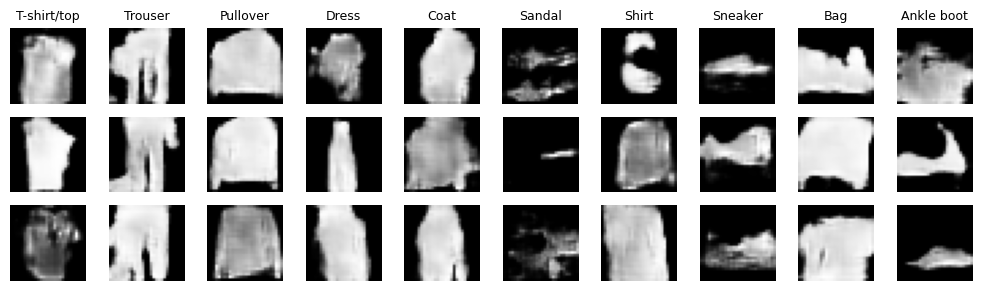

Saved models for epoch 10
Epoch [11/200] G_loss: 0.7010  D_loss: 0.6963  D(x): 0.5008  D(G(x)): 0.4986
Saved models for epoch 11
Epoch [12/200] G_loss: 0.7042  D_loss: 0.6950  D(x): 0.5025  D(G(x)): 0.4977
Saved models for epoch 12
Epoch [13/200] G_loss: 0.6996  D_loss: 0.6954  D(x): 0.5015  D(G(x)): 0.4991
Saved models for epoch 13
Epoch [14/200] G_loss: 0.6998  D_loss: 0.6955  D(x): 0.5018  D(G(x)): 0.4991
Saved models for epoch 14
Epoch [15/200] G_loss: 0.7005  D_loss: 0.6954  D(x): 0.5011  D(G(x)): 0.4986
Saved models for epoch 15
Epoch [16/200] G_loss: 0.6995  D_loss: 0.6954  D(x): 0.5011  D(G(x)): 0.4989
Saved models for epoch 16
Epoch [17/200] G_loss: 0.7014  D_loss: 0.6950  D(x): 0.5016  D(G(x)): 0.4984
Saved models for epoch 17
Epoch [18/200] G_loss: 0.7024  D_loss: 0.6944  D(x): 0.5016  D(G(x)): 0.4979
Saved models for epoch 18
Epoch [19/200] G_loss: 0.6999  D_loss: 0.6956  D(x): 0.5011  D(G(x)): 0.4989
Saved models for epoch 19
Epoch [20/200] G_loss: 0.6998  D_loss: 0.6955  

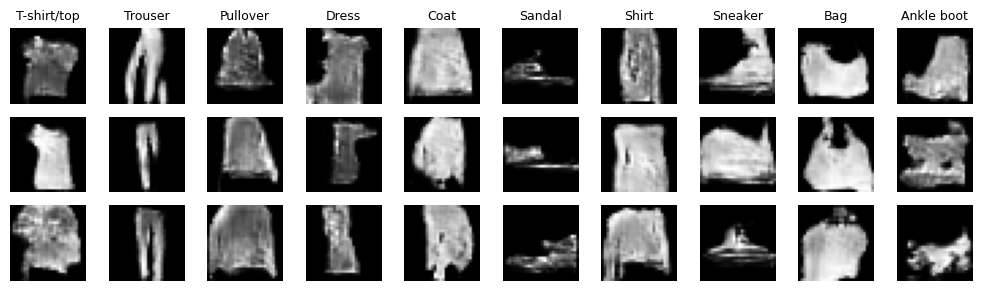

Saved models for epoch 20
Epoch [21/200] G_loss: 0.7014  D_loss: 0.6941  D(x): 0.5017  D(G(x)): 0.4981
Saved models for epoch 21
Epoch [22/200] G_loss: 0.6996  D_loss: 0.6952  D(x): 0.5012  D(G(x)): 0.4989
Saved models for epoch 22
Epoch [23/200] G_loss: 0.6994  D_loss: 0.6945  D(x): 0.5019  D(G(x)): 0.4989
Saved models for epoch 23
Epoch [24/200] G_loss: 0.7015  D_loss: 0.6940  D(x): 0.5022  D(G(x)): 0.4982
Saved models for epoch 24
Epoch [25/200] G_loss: 0.7041  D_loss: 0.6934  D(x): 0.5019  D(G(x)): 0.4970
Saved models for epoch 25
Epoch [26/200] G_loss: 0.7030  D_loss: 0.6934  D(x): 0.5022  D(G(x)): 0.4975
Saved models for epoch 26
Epoch [27/200] G_loss: 0.7029  D_loss: 0.6934  D(x): 0.5025  D(G(x)): 0.4976
Saved models for epoch 27
Epoch [28/200] G_loss: 0.7023  D_loss: 0.6937  D(x): 0.5017  D(G(x)): 0.4977
Saved models for epoch 28
Epoch [29/200] G_loss: 0.7008  D_loss: 0.6940  D(x): 0.5022  D(G(x)): 0.4984
Saved models for epoch 29
Epoch [30/200] G_loss: 0.7003  D_loss: 0.6946  

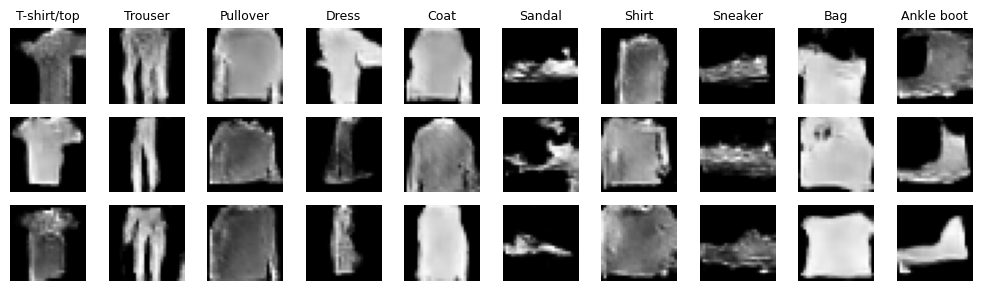

Saved models for epoch 30
Epoch [31/200] G_loss: 0.7022  D_loss: 0.6932  D(x): 0.5023  D(G(x)): 0.4977
Saved models for epoch 31
Epoch [32/200] G_loss: 0.7038  D_loss: 0.6931  D(x): 0.5029  D(G(x)): 0.4973
Saved models for epoch 32
Epoch [33/200] G_loss: 0.7009  D_loss: 0.6940  D(x): 0.5019  D(G(x)): 0.4983
Saved models for epoch 33
Epoch [34/200] G_loss: 0.7035  D_loss: 0.6934  D(x): 0.5023  D(G(x)): 0.4973
Saved models for epoch 34
Epoch [35/200] G_loss: 0.7006  D_loss: 0.6942  D(x): 0.5019  D(G(x)): 0.4985
Saved models for epoch 35
Epoch [36/200] G_loss: 0.7013  D_loss: 0.6939  D(x): 0.5021  D(G(x)): 0.4982
Saved models for epoch 36
Epoch [37/200] G_loss: 0.7029  D_loss: 0.6927  D(x): 0.5023  D(G(x)): 0.4973
Saved models for epoch 37
Epoch [38/200] G_loss: 0.7018  D_loss: 0.6928  D(x): 0.5027  D(G(x)): 0.4978
Saved models for epoch 38
Epoch [39/200] G_loss: 0.7066  D_loss: 0.6923  D(x): 0.5035  D(G(x)): 0.4964
Saved models for epoch 39
Epoch [40/200] G_loss: 0.7074  D_loss: 0.6911  

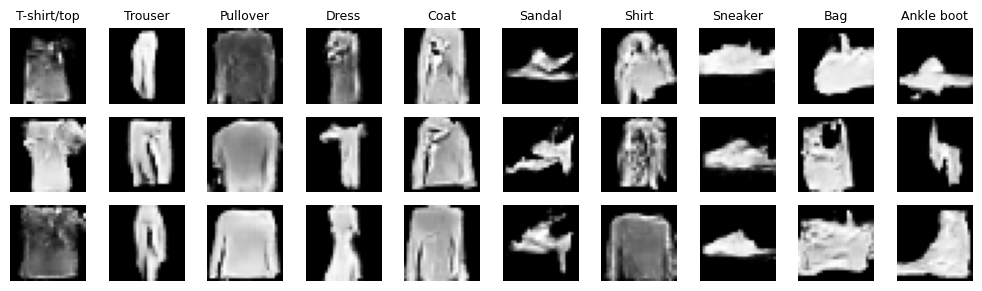

Saved models for epoch 40
Epoch [41/200] G_loss: 0.7080  D_loss: 0.6913  D(x): 0.5041  D(G(x)): 0.4958
Saved models for epoch 41
Epoch [42/200] G_loss: 0.7081  D_loss: 0.6913  D(x): 0.5042  D(G(x)): 0.4958
Saved models for epoch 42
Epoch [43/200] G_loss: 0.7073  D_loss: 0.6909  D(x): 0.5036  D(G(x)): 0.4957
Saved models for epoch 43
Epoch [44/200] G_loss: 0.7075  D_loss: 0.6913  D(x): 0.5040  D(G(x)): 0.4959
Saved models for epoch 44
Epoch [45/200] G_loss: 0.7112  D_loss: 0.6895  D(x): 0.5054  D(G(x)): 0.4945
Saved models for epoch 45
Epoch [46/200] G_loss: 0.7115  D_loss: 0.6900  D(x): 0.5053  D(G(x)): 0.4945
Saved models for epoch 46
Epoch [47/200] G_loss: 0.7122  D_loss: 0.6890  D(x): 0.5054  D(G(x)): 0.4940
Saved models for epoch 47
Epoch [48/200] G_loss: 0.7139  D_loss: 0.6886  D(x): 0.5061  D(G(x)): 0.4936
Saved models for epoch 48
Epoch [49/200] G_loss: 0.7153  D_loss: 0.6876  D(x): 0.5070  D(G(x)): 0.4931
Saved models for epoch 49
Epoch [50/200] G_loss: 0.7138  D_loss: 0.6884  

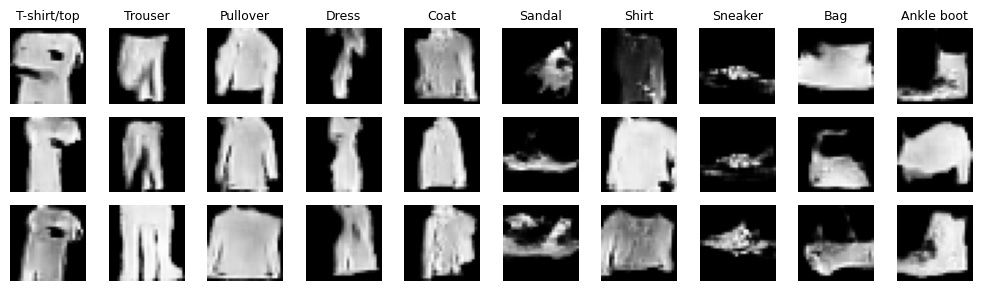

Saved models for epoch 50
Epoch [51/200] G_loss: 0.7188  D_loss: 0.6860  D(x): 0.5080  D(G(x)): 0.4917
Saved models for epoch 51
Epoch [52/200] G_loss: 0.7201  D_loss: 0.6859  D(x): 0.5086  D(G(x)): 0.4914
Saved models for epoch 52
Epoch [53/200] G_loss: 0.7237  D_loss: 0.6847  D(x): 0.5094  D(G(x)): 0.4902
Saved models for epoch 53
Epoch [54/200] G_loss: 0.7240  D_loss: 0.6846  D(x): 0.5098  D(G(x)): 0.4901
Saved models for epoch 54
Epoch [55/200] G_loss: 0.7278  D_loss: 0.6837  D(x): 0.5111  D(G(x)): 0.4890
Saved models for epoch 55
Epoch [56/200] G_loss: 0.7246  D_loss: 0.6849  D(x): 0.5095  D(G(x)): 0.4900
Saved models for epoch 56
Epoch [57/200] G_loss: 0.7254  D_loss: 0.6835  D(x): 0.5108  D(G(x)): 0.4896
Saved models for epoch 57
Epoch [58/200] G_loss: 0.7326  D_loss: 0.6797  D(x): 0.5135  D(G(x)): 0.4870
Saved models for epoch 58
Epoch [59/200] G_loss: 0.7376  D_loss: 0.6789  D(x): 0.5139  D(G(x)): 0.4852
Saved models for epoch 59
Epoch [60/200] G_loss: 0.7416  D_loss: 0.6772  

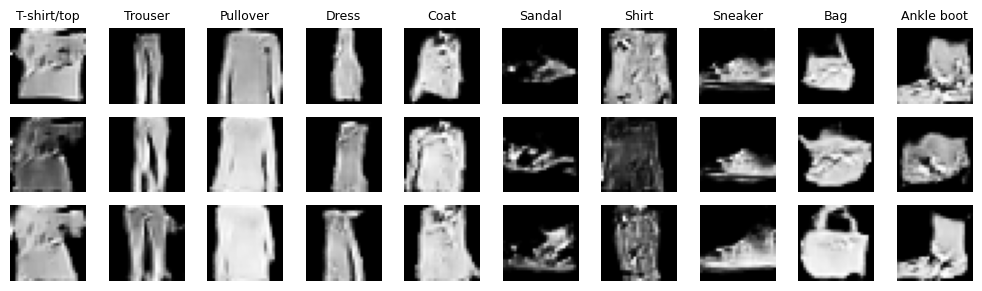

Saved models for epoch 60
Epoch [61/200] G_loss: 0.7408  D_loss: 0.6776  D(x): 0.5159  D(G(x)): 0.4845
Saved models for epoch 61
Epoch [62/200] G_loss: 0.7398  D_loss: 0.6784  D(x): 0.5152  D(G(x)): 0.4848
Saved models for epoch 62
Epoch [63/200] G_loss: 0.7502  D_loss: 0.6729  D(x): 0.5190  D(G(x)): 0.4809
Saved models for epoch 63
Epoch [64/200] G_loss: 0.7558  D_loss: 0.6701  D(x): 0.5207  D(G(x)): 0.4787
Saved models for epoch 64
Epoch [65/200] G_loss: 0.7596  D_loss: 0.6684  D(x): 0.5227  D(G(x)): 0.4776
Saved models for epoch 65
Epoch [66/200] G_loss: 0.7684  D_loss: 0.6648  D(x): 0.5246  D(G(x)): 0.4742
Saved models for epoch 66
Epoch [67/200] G_loss: 0.7707  D_loss: 0.6674  D(x): 0.5248  D(G(x)): 0.4744
Saved models for epoch 67
Epoch [68/200] G_loss: 0.7624  D_loss: 0.6696  D(x): 0.5228  D(G(x)): 0.4771
Saved models for epoch 68
Epoch [69/200] G_loss: 0.7702  D_loss: 0.6651  D(x): 0.5255  D(G(x)): 0.4741
Saved models for epoch 69
Epoch [70/200] G_loss: 0.7824  D_loss: 0.6584  

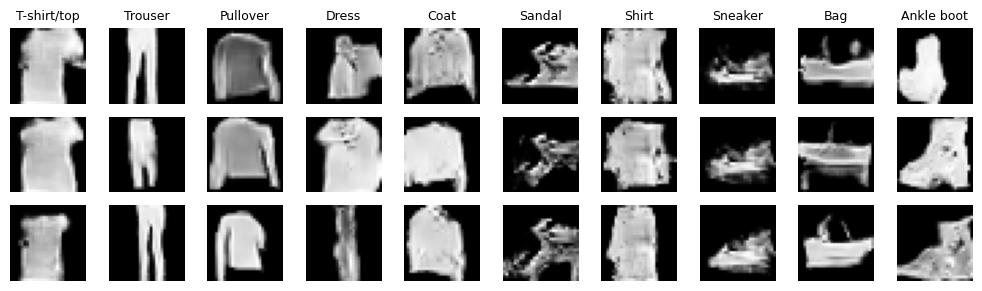

Saved models for epoch 70
Epoch [71/200] G_loss: 0.7833  D_loss: 0.6617  D(x): 0.5296  D(G(x)): 0.4702
Saved models for epoch 71
Epoch [72/200] G_loss: 0.7890  D_loss: 0.6603  D(x): 0.5309  D(G(x)): 0.4685
Saved models for epoch 72
Epoch [73/200] G_loss: 0.7920  D_loss: 0.6562  D(x): 0.5328  D(G(x)): 0.4667
Saved models for epoch 73
Epoch [74/200] G_loss: 0.7972  D_loss: 0.6560  D(x): 0.5347  D(G(x)): 0.4656
Saved models for epoch 74
Epoch [75/200] G_loss: 0.7999  D_loss: 0.6553  D(x): 0.5348  D(G(x)): 0.4647
Saved models for epoch 75
Epoch [76/200] G_loss: 0.7910  D_loss: 0.6601  D(x): 0.5318  D(G(x)): 0.4676
Saved models for epoch 76
Epoch [77/200] G_loss: 0.8019  D_loss: 0.6572  D(x): 0.5353  D(G(x)): 0.4650
Saved models for epoch 77
Epoch [78/200] G_loss: 0.8098  D_loss: 0.6531  D(x): 0.5377  D(G(x)): 0.4617
Saved models for epoch 78
Epoch [79/200] G_loss: 0.8067  D_loss: 0.6505  D(x): 0.5381  D(G(x)): 0.4618
Saved models for epoch 79
Epoch [80/200] G_loss: 0.8134  D_loss: 0.6505  

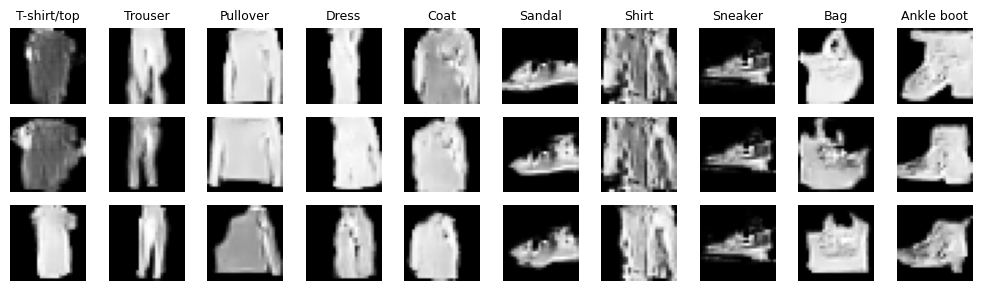

Saved models for epoch 80
Epoch [81/200] G_loss: 0.8060  D_loss: 0.6561  D(x): 0.5367  D(G(x)): 0.4634
Saved models for epoch 81
Epoch [82/200] G_loss: 0.8077  D_loss: 0.6524  D(x): 0.5378  D(G(x)): 0.4618
Saved models for epoch 82
Epoch [83/200] G_loss: 0.8196  D_loss: 0.6451  D(x): 0.5418  D(G(x)): 0.4575
Saved models for epoch 83
Epoch [84/200] G_loss: 0.8201  D_loss: 0.6467  D(x): 0.5428  D(G(x)): 0.4573
Saved models for epoch 84
Epoch [85/200] G_loss: 0.8513  D_loss: 0.6323  D(x): 0.5523  D(G(x)): 0.4473
Saved models for epoch 85
Epoch [86/200] G_loss: 0.8460  D_loss: 0.6332  D(x): 0.5521  D(G(x)): 0.4483
Saved models for epoch 86
Epoch [87/200] G_loss: 0.8434  D_loss: 0.6390  D(x): 0.5490  D(G(x)): 0.4506
Saved models for epoch 87
Epoch [88/200] G_loss: 0.8697  D_loss: 0.6268  D(x): 0.5573  D(G(x)): 0.4424
Saved models for epoch 88
Epoch [89/200] G_loss: 0.8635  D_loss: 0.6314  D(x): 0.5545  D(G(x)): 0.4450
Saved models for epoch 89
Epoch [90/200] G_loss: 0.8513  D_loss: 0.6360  

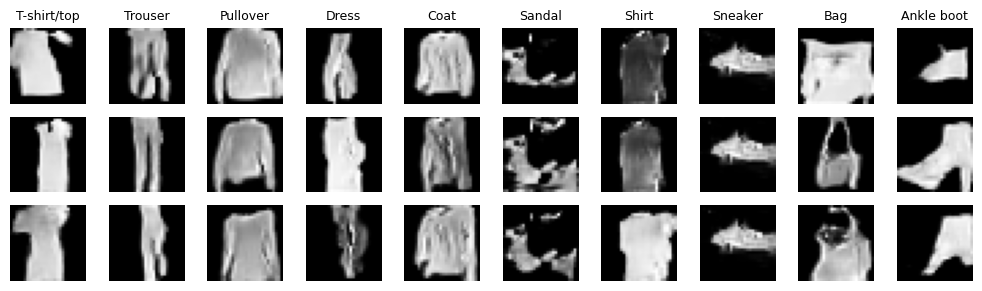

Saved models for epoch 90
Epoch [91/200] G_loss: 0.8797  D_loss: 0.6260  D(x): 0.5595  D(G(x)): 0.4398
Saved models for epoch 91
Epoch [92/200] G_loss: 0.8593  D_loss: 0.6365  D(x): 0.5528  D(G(x)): 0.4466
Saved models for epoch 92
Epoch [93/200] G_loss: 0.8647  D_loss: 0.6336  D(x): 0.5557  D(G(x)): 0.4446
Saved models for epoch 93
Epoch [94/200] G_loss: 0.8884  D_loss: 0.6213  D(x): 0.5629  D(G(x)): 0.4365
Saved models for epoch 94
Epoch [95/200] G_loss: 0.8730  D_loss: 0.6330  D(x): 0.5571  D(G(x)): 0.4428
Saved models for epoch 95
Epoch [96/200] G_loss: 0.8846  D_loss: 0.6214  D(x): 0.5629  D(G(x)): 0.4378
Saved models for epoch 96
Epoch [97/200] G_loss: 0.9184  D_loss: 0.6074  D(x): 0.5716  D(G(x)): 0.4276
Saved models for epoch 97
Epoch [98/200] G_loss: 0.9026  D_loss: 0.6172  D(x): 0.5668  D(G(x)): 0.4330
Saved models for epoch 98
Epoch [99/200] G_loss: 0.9088  D_loss: 0.6174  D(x): 0.5682  D(G(x)): 0.4314
Saved models for epoch 99
Epoch [100/200] G_loss: 0.9030  D_loss: 0.6156 

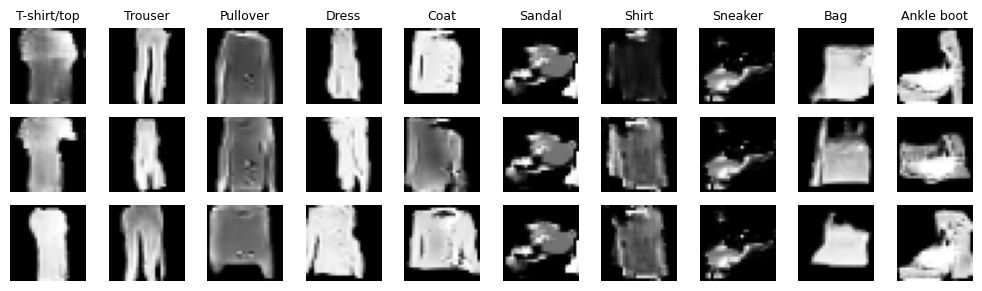

Saved models for epoch 100
Epoch [101/200] G_loss: 0.9134  D_loss: 0.6158  D(x): 0.5698  D(G(x)): 0.4298
Saved models for epoch 101
Epoch [102/200] G_loss: 0.9135  D_loss: 0.6099  D(x): 0.5726  D(G(x)): 0.4290
Saved models for epoch 102
Epoch [103/200] G_loss: 0.9207  D_loss: 0.6104  D(x): 0.5716  D(G(x)): 0.4274
Saved models for epoch 103
Epoch [104/200] G_loss: 0.9121  D_loss: 0.6215  D(x): 0.5683  D(G(x)): 0.4317
Saved models for epoch 104
Epoch [105/200] G_loss: 0.9245  D_loss: 0.6107  D(x): 0.5731  D(G(x)): 0.4259
Saved models for epoch 105
Epoch [106/200] G_loss: 0.9116  D_loss: 0.6197  D(x): 0.5685  D(G(x)): 0.4305
Saved models for epoch 106
Epoch [107/200] G_loss: 0.9575  D_loss: 0.5869  D(x): 0.5868  D(G(x)): 0.4139
Saved models for epoch 107
Epoch [108/200] G_loss: 0.9437  D_loss: 0.6059  D(x): 0.5771  D(G(x)): 0.4223
Saved models for epoch 108
Epoch [109/200] G_loss: 0.9587  D_loss: 0.5891  D(x): 0.5855  D(G(x)): 0.4140
Saved models for epoch 109
Epoch [110/200] G_loss: 0.91

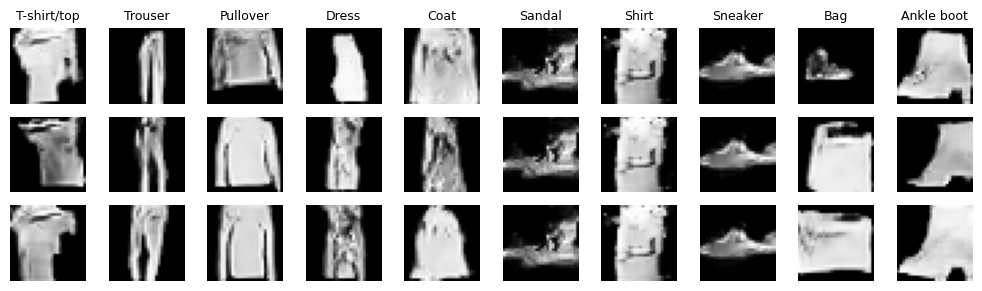

Saved models for epoch 110
Epoch [111/200] G_loss: 0.9272  D_loss: 0.6105  D(x): 0.5755  D(G(x)): 0.4246
Saved models for epoch 111
Epoch [112/200] G_loss: 0.9238  D_loss: 0.6159  D(x): 0.5728  D(G(x)): 0.4278
Saved models for epoch 112
Epoch [113/200] G_loss: 0.9307  D_loss: 0.6069  D(x): 0.5769  D(G(x)): 0.4234
Saved models for epoch 113
Epoch [114/200] G_loss: 0.9188  D_loss: 0.6125  D(x): 0.5731  D(G(x)): 0.4273
Saved models for epoch 114
Epoch [115/200] G_loss: 0.9750  D_loss: 0.5892  D(x): 0.5884  D(G(x)): 0.4114
Saved models for epoch 115
Epoch [116/200] G_loss: 0.9598  D_loss: 0.5930  D(x): 0.5847  D(G(x)): 0.4142
Saved models for epoch 116
Epoch [117/200] G_loss: 0.9595  D_loss: 0.5979  D(x): 0.5838  D(G(x)): 0.4159
Saved models for epoch 117
Epoch [118/200] G_loss: 0.9474  D_loss: 0.6078  D(x): 0.5789  D(G(x)): 0.4208
Saved models for epoch 118
Epoch [119/200] G_loss: 0.9728  D_loss: 0.5858  D(x): 0.5896  D(G(x)): 0.4094
Saved models for epoch 119
Epoch [120/200] G_loss: 0.98

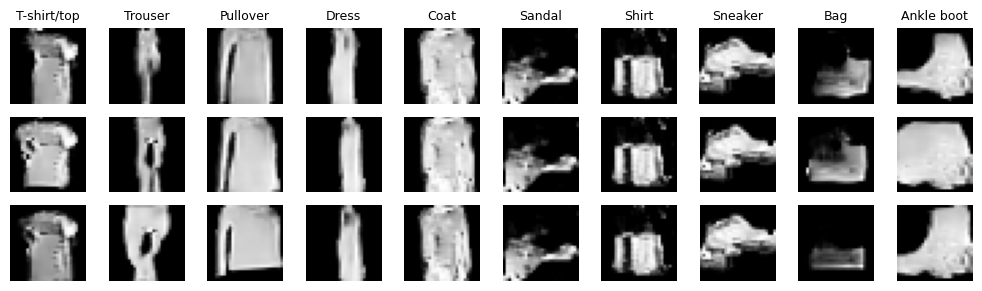

Saved models for epoch 120
Epoch [121/200] G_loss: 0.9917  D_loss: 0.5757  D(x): 0.5955  D(G(x)): 0.4037
Saved models for epoch 121
Epoch [122/200] G_loss: 0.9836  D_loss: 0.5831  D(x): 0.5936  D(G(x)): 0.4067
Saved models for epoch 122
Epoch [123/200] G_loss: 1.0141  D_loss: 0.5677  D(x): 0.6033  D(G(x)): 0.3968
Saved models for epoch 123
Epoch [124/200] G_loss: 1.0661  D_loss: 0.5426  D(x): 0.6199  D(G(x)): 0.3809
Saved models for epoch 124
Epoch [125/200] G_loss: 0.9743  D_loss: 0.5911  D(x): 0.5907  D(G(x)): 0.4094
Saved models for epoch 125
Epoch [126/200] G_loss: 0.9906  D_loss: 0.5806  D(x): 0.5953  D(G(x)): 0.4047
Saved models for epoch 126
Epoch [127/200] G_loss: 1.0036  D_loss: 0.5743  D(x): 0.5989  D(G(x)): 0.4005
Saved models for epoch 127
Epoch [128/200] G_loss: 1.0077  D_loss: 0.5808  D(x): 0.5981  D(G(x)): 0.4017
Saved models for epoch 128


In [ ]:
#@title 학습 실행

train_cgan(
    num_epochs=num_epochs,
    generator=generator.to(device),
    discriminator=discriminator.to(device),
    optimizer_G=optimizer_G,
    optimizer_D=optimizer_D,
    adversarial_loss=torch.nn.BCELoss(),
    train_loader=train_loader,
    device=device,
    latent_dim=latent_dim,
    num_classes=num_classes,
    idx_to_class=idx_to_class,
)

# **4. 모델 평가**

In [ ]:
#@title 학습된 모델 로드
# Generator 모델을 다시 인스턴스화합니다.
generator_loaded = Generator().to(device)
# 저장된 state_dict를 로드합니다. 파일 경로를 정확하게 지정해야 합니다.
# 예시: 마지막 에폭(num_epochs)의 모델을 로드
model_path = os.path.join(g_path, f"generator_epoch_{num_epochs}.pth")
generator_loaded.load_state_dict(torch.load(model_path, map_location=device))
generator_loaded.eval() # 평가 모드로 설정 (Dropout, BatchNorm 등이 평가 모드로 동작)

print(f"Generator model loaded from {model_path}")

In [ ]:
#@title Inception Model 준비
import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import numpy as np

# Inception‑v3 모델 준비 (FID용: fc를 Identity로 변경)
inception_model_fid = inception_v3(weights="IMAGENET1K_V1", transform_input=False).to(device)
inception_model_fid.fc = torch.nn.Identity()  # fc 제거해서 2048차원 feature 반환
inception_model_fid.eval()

# Inception‑v3 모델 준비 (IS용: 기본 모델)
inception_model_is = inception_v3(weights="IMAGENET1K_V1", transform_input=False).to(device)
inception_model_is.eval()
print("Inception model loaded")


Fréchet Inception Distance

- 생성 분포와 실제 데이터 분포간의 거리 측정
- 거리가 가까울수록 (FID 값이 작을 수록) 실제 분포와 유사한 데이터가 생성

In [ ]:
#@title Inception Feature 추출 함수 + Fréchet Inception Distance (FID) 계산 함수

# 입력 이미지는 [0,1] 범위, 크기 28x28, 채널: 1 (grayscale)
# Inception‑v3는 (3,299,299) 크기의 이미지를 요구하므로, 변환 과정을 포함.
def get_inception_features(images, model, batch_size=32, device=device):
    """
    Inception-v3 모델을 사용하여 이미지에서 특징 추출
    """
    model.eval() # 모델을 평가 모드로 설정
    n_images = images.shape[0]
    features = []
    # Inception‑v3의 입력 정규화 값 (ImageNet)
    norm_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    norm_std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
    with torch.no_grad(): # 그래디언트 계산 비활성화
        for i in range(0, n_images, batch_size):
            batch = images[i:i+batch_size]
            # 만약 grayscale이면 3채널로 변환
            if batch.shape[1] == 1:
                batch = batch.repeat(1,3,1,1)
            # 299x299로 업샘플링
            batch = F.interpolate(batch, size=(299,299), mode='bilinear', align_corners=False)
            # 정규화
            batch = (batch - norm_mean) / norm_std
            pred = model(batch) # Inception-v3 모델에 입력하여 특징 추출
            features.append(pred.cpu().numpy()) # 추출된 특징을 CPU로 이동하여 numpy 배열로 변환
    features = np.concatenate(features, axis=0) # 모든 배치의 특징을 하나로 연결
    return features


def calculate_fid(real_images, generated_images, model, batch_size=32, device=device):
    """
    실제 이미지와 생성된 이미지 간의 FID (Fréchet Inception Distance) 계산
    """
    # real_images, generated_images: torch.Tensor, [0,1] 범위
    act_real = get_inception_features(real_images, model, batch_size, device) # 실제 이미지 특징 추출
    act_gen  = get_inception_features(generated_images, model, batch_size, device) # 생성된 이미지 특징 추출

    mu_real = np.mean(act_real, axis=0) # 실제 이미지 특징의 평균 계산
    mu_gen  = np.mean(act_gen, axis=0) # 생성된 이미지 특징의 평균 계산
    sigma_real = np.cov(act_real, rowvar=False) # 실제 이미지 특징의 공분산 행렬 계산
    sigma_gen  = np.cov(act_gen, rowvar=False) # 생성된 이미지 특징의 공분산 행렬 계산

    # Frechet Distance 공식
    diff = mu_real - mu_gen
    # 공분산 행렬의 제곱근 계산
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    # 만약 복소수 부분이 생기면 실수부만 취함
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # FID 계산
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

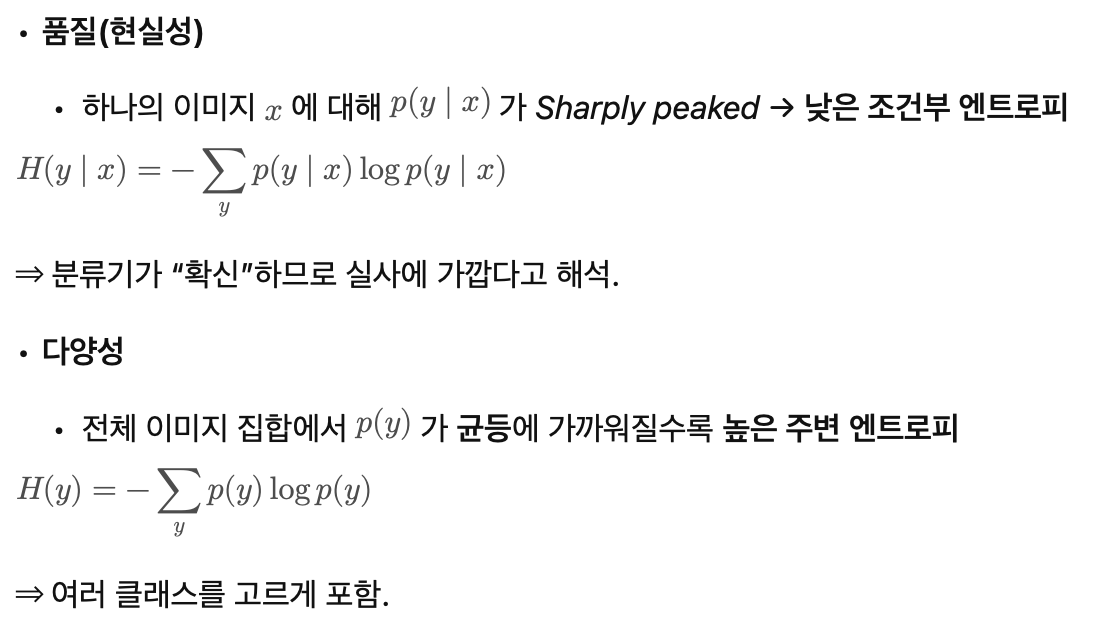


In [ ]:
#@title Inception Prediction 함수 + Inception Score (IS) 계산 함수

def get_inception_predictions(images, model, batch_size=32, device=device):
    """
    Inception-v3 모델을 사용하여 이미지의 클래스 예측 확률 추출
    """
    model.eval() # 모델을 평가 모드로 설정
    n_images = images.shape[0]
    preds = []
    norm_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    norm_std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
    with torch.no_grad(): # 그래디언트 계산 비활성화
        for i in range(0, n_images, batch_size):
            batch = images[i:i+batch_size]
            if batch.shape[1] == 1:
                batch = batch.repeat(1,3,1,1)
            batch = F.interpolate(batch, size=(299,299), mode='bilinear', align_corners=False)
            batch = (batch - norm_mean) / norm_std

            logits = model(batch)  # 모델의 출력: (N, 1000) - 클래스별 로짓
            p = F.softmax(logits, dim=1) # 소프트맥스 함수를 적용하여 확률로 변환
            preds.append(p.cpu().numpy()) # 예측 확률을 CPU로 이동하여 numpy 배열로 변환
    preds = np.concatenate(preds, axis=0) # 모든 배치의 예측 확률을 하나로 연결
    return preds

def calculate_inception_score(
        generated_images,      # 생성된 이미지 텐서, 값 범위 [0,1]
        model,                 # 사전학습 Inception-v3 (softmax 출력 유지)
        batch_size: int = 32,  # 추론 시 배치 크기
        splits: int = 10,      # 이미지 분할(split) 개수
        device=device):        # 연산 장치(GPU/CPU)

    # 1) 모든 생성 이미지를 Inception-v3에 통과시켜 각 이미지의 클래스 확률 p(y|x)  (N, 1000) 배열 추출
    preds = get_inception_predictions(
        generated_images, model,
        batch_size=batch_size, device=device)

    N = preds.shape[0]          # 전체 이미지 수
    split_scores = []           # 분할별 IS를 저장할 리스트

    # 2) 데이터를 `splits` 개 구간으로 나눠 분할별 IS 계산 - 편향·분산 추정 안정화  (보통 10 등분 사용)
    for i in range(splits):
        # i번째 분할(slice) 선택  -> shape: (N/splits, 1000)
        part = preds[i * (N // splits):(i + 1) * (N // splits), :]

        # 분할 내부 평균 확률  p(y)
        py = np.mean(part, axis=0)

        scores = []  # 해당 분할에서 각 이미지의 KL 값 저장

        # 3) 각 이미지에 대해 KL(p(y|x) || p(y)) = Σ p(y|x) * (log p(y|x) - log p(y))
        for j in range(part.shape[0]):
            pyx = part[j, :]
            # log(0) 방지를 위한 1e-10 추가
            kl = np.sum(pyx * (np.log(pyx + 1e-10) - np.log(py + 1e-10)))
            scores.append(kl)

        # 분할 KL 평균을 지수화(exp) → 분할 IS
        split_is = np.exp(np.mean(scores))
        split_scores.append(split_is)

    # 4) 모든 분할 IS의 평균·표준편차 산출
    inception_score = np.mean(split_scores)
    inception_std   = np.std(split_scores)

    return inception_score, inception_std

In [ ]:
#@title 평가지표 확인

# 학습 종료 후 평가 (예: 1000개 샘플 사용)
n_eval = 1000

# 생성 이미지 준비
z = torch.randn(n_eval, latent_dim, device=device) # 평가에 사용할 노이즈 벡터 생성
eval_labels = torch.randint(0, num_classes, (n_eval,), device=device) # 평가에 사용할 랜덤 레이블 생성
gen_imgs = generator(z, eval_labels) # 생성자에 노이즈와 레이블을 입력하여 이미지 생성
gen_imgs = (gen_imgs + 1) / 2.0  # [-1,1] -> [0,1] 범위로 스케일링

# 실제 이미지 준비 (test dataset에서 n_eval개 샘플)
real_imgs_list = []
for imgs, _ in test_loader:
    real_imgs_list.append(imgs)
    if len(real_imgs_list) * imgs.size(0) >= n_eval:
        break
real_imgs = torch.cat(real_imgs_list, 0)[:n_eval].to(device) # 테스트 데이터셋에서 실제 이미지 샘플링
real_imgs = (real_imgs + 1) / 2.0  # [-1,1] -> [0,1] 범위로 스케일링

# FID 계산
fid_score = calculate_fid(real_imgs, gen_imgs, inception_model_fid, batch_size=32, device=device)
# Inception Score 계산
inception_score, inception_std = calculate_inception_score(gen_imgs, inception_model_is, batch_size=32, splits=10, device=device)

print(f"FID score: {fid_score:.4f}")
print(f"Inception Score: Mean = {inception_score:.4f}, Std = {inception_std:.4f}")